# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:

import splitfolders
output = splitfolders.ratio("/data/landmark_images/train", output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

ModuleNotFoundError: No module named 'splitfolders'

In [17]:
output = splitfolders.ratio("/data/landmark_images/test", output="output", seed=1337, ratio=(1, 0), group_prefix=None)

Copying files: 1250 files [00:03, 408.66 files/s]


In [19]:
pwd

'/home/workspace/nd101-c2-landmarks-starter/landmark_project'

In [3]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2    
    
# define training and test data directories
#train_dir = '/data/landmark_images/train'
train_dir = 'train'
#test_dir = '/data/landmark_images/test'
test_dir = 'test'
#valid_dir = '/data/landmark_images/valid'
valid_dir = 'val'
#nd101-c2-landmarks-starter/landmark_project/images/valid/train/00.Haleakala_National_Park


#data_transform = transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomRotation(5),
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),transforms.ToTensor()])

train_transform = transforms.Compose(
		[transforms.RandomResizedCrop(256),
         transforms.RandomRotation(5),
		 transforms.ToTensor(),
		 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_val_transform = transforms.Compose(
		[transforms.RandomResizedCrop(256),
		 transforms.ToTensor(),
		 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_val_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_val_transform)

num_train = len(train_data)
train_indices = list(range(num_train))
np.random.shuffle(train_indices)

num_valid = len(valid_data)
valid_indices = list(range(num_valid))
np.random.shuffle(valid_indices)

num_test = len(test_data)
test_indices = list(range(num_test))
np.random.shuffle(test_indices)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

## Specify appropriate transforms, and batch_sizes

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


CUDA is available!  Training on GPU ...


In [11]:
images, labels = next(iter(loaders_scratch['train']))
images = images.numpy() 
print(images.shape, labels)

(20, 3, 256, 256) tensor([ 47,  37,  39,  32,  37,  25,  25,  28,   4,  31,  39,   0,
          5,  18,   0,   9,  31,  40,  48,  25])


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?

- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not? 


**Answer**: 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
I resized the images to 256x256 to make for convenient use in the convolutional layers. This would result in a 3x256x256 = 196,608 tensor.
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not? 
I considered including both horizontal flip and vertical flip but reasoned that the only way to get a horizontal flip would be to have taken a picture of the landmark in a mirror and that seemed unlikely and so would introduce noise without adding much robustness. The vertical flip seemed a bad idea as images would typically be captured with the camera oriented vertically. I did include +/- 5 degree rotation as an allowance for pictures sometimes being taken at awkward angles.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

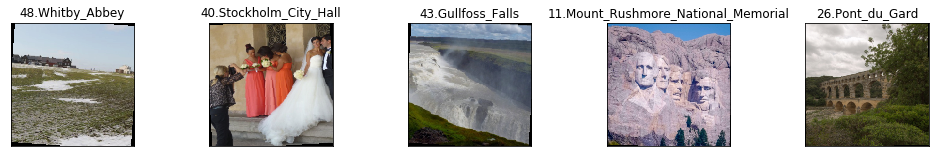

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader
class_names = train_data.classes

# helper function to un-normalize and display an image
def imshow(inp, title=None):    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
# obtain 5 images of 1 batch from the trainingset dataloader
dataiter = iter(train_loader)
images, labels = dataiter.next()
#images = images.numpy()
#
fig = plt.figure(figsize=(35, 5))
# display 5 images
for idx in np.arange(5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[labels[idx]])   


### Initialize use_cuda variable

In [5]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [6]:
## TODO: select loss function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [7]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # convolutional layer (sees 3x256x256 image tensor)
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        
        # convolutional layer (sees 16x128x128 image tensor)
        # conv layer (depth from 16 --> 32), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # convolutional layer (sees 32x64x64 image tensor)
        # conv layer (depth from 32 --> 64), 3x3 kernels        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  

        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer (64 * 32 * 32 -> 512)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        # linear layer (512 -> 50)
        self.fc2 = nn.Linear(512, 50)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
  
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        #print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.size())

        # flatten image input
        x = x.view(-1, 64 * 32 * 32)
        x.size()
        # add dropout layer
        x = self.dropout(x)
        x.size()
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x.size()
        # add dropout layer
        x = self.dropout(x)
        x.size()
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)        
        x.size()
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I cropped my images during preprocessing to be a clean multiple of 2 and then used that for easier math during the convolution layer definition. I ingest the 3 layers (RGB) at the front of the process and go directly to 16 filters, then use the standard maxpool of size 2 and stride 2 to reduce the dimensions by half each cycle while increaseing the number of filter by a factor of 2 as well. Wash, rinse and repeat for 3 rounds and then go to flattening, dropout and linear and finally to the 50 element last stage.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    from workspace_utils import active_session

    with active_session():
    # do long-running work here
        valid_loss_min = np.Inf 

        for epoch in range(1, n_epochs+1):
            # initialize variables to monitor training and validation loss
            train_loss = 0.0
            valid_loss = 0.0

            ###################
            # train the model #
            ###################
            # set the module to training mode
            model.train()
            for batch_idx, (data, target) in enumerate(loaders['train']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()

                ## TODO: find the loss and update the model parameters accordingly
                ## record the average training loss, using something like
                ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
                    # clear the gradients of all optimized variables
                    optimizer.zero_grad()
                    # forward pass: compute predicted outputs by passing inputs to the model
                    output = model(data)
                    # calculate the loss
                    loss = criterion(output, target)
                    # backward pass: compute gradient of the loss with respect to model parameters
                    loss.backward()
                    # perform a single optimization step (parameter update)
                    optimizer.step()
                    # update running training loss
                    train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            ######################    
            # validate the model #
            ######################
            # set the model to evaluation mode
            model.eval()
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()

                ## TODO: update average validation loss 
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the loss
                loss = criterion(output, target)
                # update running validation loss 
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

                # print training/validation statistics 
            # calculate average loss over an epoch
            #train_loss = train_loss/len(train_loader)
            #valid_loss = valid_loss/len(valid_loader)    


            # print training/validation statistics 
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

            ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss

        return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [18]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(2, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.912286 	Validation Loss: 3.915566
Validation loss decreased (inf --> 3.915566).  Saving model ...


KeyboardInterrupt: 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [19]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.909524 	Validation Loss: 3.900530
Validation loss decreased (inf --> 3.900530).  Saving model ...
Epoch: 2 	Training Loss: 3.900605 	Validation Loss: 3.897384
Validation loss decreased (3.900530 --> 3.897384).  Saving model ...
Epoch: 3 	Training Loss: 3.890073 	Validation Loss: 3.889012
Validation loss decreased (3.897384 --> 3.889012).  Saving model ...
Epoch: 4 	Training Loss: 3.878426 	Validation Loss: 3.864969
Validation loss decreased (3.889012 --> 3.864969).  Saving model ...
Epoch: 5 	Training Loss: 3.864644 	Validation Loss: 3.857115
Validation loss decreased (3.864969 --> 3.857115).  Saving model ...
Epoch: 6 	Training Loss: 3.846154 	Validation Loss: 3.820649
Validation loss decreased (3.857115 --> 3.820649).  Saving model ...
Epoch: 7 	Training Loss: 3.827284 	Validation Loss: 3.771896
Validation loss decreased (3.820649 --> 3.771896).  Saving model ...
Epoch: 8 	Training Loss: 3.805252 	Validation Loss: 3.729379
Validation loss decreased (3.77189

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))
model_scratch.load_state_dict(torch.load('model.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.019590


Test Accuracy: 25% (319/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#loaders_transfer = {'train': None, 'valid': None, 'test': None}
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2    
    
# define training and test data directories
#train_dir = '/data/landmark_images/train'
train_dir = 'train'
#test_dir = '/data/landmark_images/test'
test_dir = 'test'
#valid_dir = '/data/landmark_images/valid'
valid_dir = 'val'

train_transform = transforms.Compose(
		[transforms.RandomResizedCrop(224),
         transforms.RandomRotation(5),
		 transforms.ToTensor(),
		 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_val_transform = transforms.Compose(
		[transforms.RandomResizedCrop(224),
		 transforms.ToTensor(),
		 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_val_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_val_transform)

num_train = len(train_data)
train_indices = list(range(num_train))
np.random.shuffle(train_indices)

num_valid = len(valid_data)
valid_indices = list(range(num_valid))
np.random.shuffle(valid_indices)

num_test = len(test_data)
test_indices = list(range(num_test))
np.random.shuffle(test_indices)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}



CUDA is available!  Training on GPU ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [2]:
## TODO: select loss function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)
    return optimizer   
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [3]:
## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False


import torch.nn as nn

n_inputs = model_transfer.classifier[6].in_features


# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 50)

model_transfer.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model_transfer.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)
#print(vgg16)

#-#-# Do NOT modify the code below this line. #-#-#


model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 111851089.92it/s]


50


In [4]:
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))


Num training images:  3996
Num validation images:  1000
Num test images:  1250


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  The VGG model is trained on Imagenet with 1000 different image types which seem likely to have high level features like those probably found in the images of famous places I'm working with. So, I'm freezing the feature extractor portion of the model and only training on the last layer.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [5]:
def train_transfer(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    from workspace_utils import active_session

    with active_session():
    # do long-running work here
        valid_loss_min = np.Inf        
                
        for epoch in range(1, n_epochs+1):

            # keep track of training and validation loss
            train_loss = 0.0
            valid_loss = 0.0

            ###################
            # train the model #
            ###################
            # model by default is set to train
            model_transfer.train()
            for batch_idx, (data, target) in enumerate(loaders['train']):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model_transfer(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                # update training loss 
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            ######################    
            # validate the model #
            ######################
            # set the model to evaluation mode
            model_transfer.eval()
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model_transfer(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update running validation loss 
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))  


                # print training/validation statistics 
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

            ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
                torch.save(model_transfer.state_dict(), 'model_transfer.pt')
                valid_loss_min = valid_loss  
                        
        return model_transfer



In [10]:
# number of epochs to train the model
n_epochs = 10
    
model_scratch = train_transfer(n_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, train_on_gpu, 'transfer.pt')
    
    
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.085484 	Validation Loss: 2.878244
Validation loss decreased (inf --> 2.878244).  Saving model ...
Epoch: 2 	Training Loss: 2.581533 	Validation Loss: 2.396405
Validation loss decreased (2.878244 --> 2.396405).  Saving model ...
Epoch: 3 	Training Loss: 2.216687 	Validation Loss: 2.078721
Validation loss decreased (2.396405 --> 2.078721).  Saving model ...
Epoch: 4 	Training Loss: 1.965752 	Validation Loss: 1.849705
Validation loss decreased (2.078721 --> 1.849705).  Saving model ...
Epoch: 5 	Training Loss: 1.825416 	Validation Loss: 1.708230
Validation loss decreased (1.849705 --> 1.708230).  Saving model ...
Epoch: 6 	Training Loss: 1.747251 	Validation Loss: 1.579439
Validation loss decreased (1.708230 --> 1.579439).  Saving model ...
Epoch: 7 	Training Loss: 1.643620 	Validation Loss: 1.535659
Validation loss decreased (1.579439 --> 1.535659).  Saving model ...
Epoch: 8 	Training Loss: 1.571313 	Validation Loss: 1.476608
Validation loss decreased (1.53565

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [8]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [11]:
test(loaders_transfer, model_transfer, criterion_transfer, train_on_gpu)

Test Loss: 1.312251


Test Accuracy: 66% (825/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [1]:
import cv2
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
test_val_transform = transforms.Compose(
		[transforms.RandomResizedCrop(224),
		 transforms.ToTensor(),
		 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
# load the model that got the best validation accuracy
model_transfer = models.vgg16(pretrained=True)
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 50)
model_transfer.classifier[6] = last_layer

model_transfer.load_state_dict(torch.load('model_transfer.pt'))
model_transfer = model_transfer.cuda()

CUDA is available!  Training on GPU ...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 120555985.71it/s]


In [5]:
import torch.nn.functional as F
def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    #get the image
    image = Image.open(img_path)
    #perform the transform
    image = test_val_transform(image)
    #unsqueeze the image
    image = torch.unsqueeze(image,0).float()
    
    if train_on_gpu:
        image = image.cuda()
    #run the image through the model and get the output
    output = model_transfer(image)
    #get the probabilities
    probs = F.softmax(output, dim=1)
    #use topk
    vals, indxs = torch.topk(probs,k)
    vals = vals.detach().cpu().numpy()
    indxs = indxs.cpu().numpy()
    names = [class_names[val]for val in indxs[0]]
    print(names)
    
    
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

RuntimeError: size mismatch, m1: [1 x 32768], m2: [25088 x 4096] at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THC/generic/THCTensorMathBlas.cu:249

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

